Linear Regression

In [24]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


Import encoded dataframe

In [25]:
#df_train = pd.read_pickle("df_train.pkl")
#df_train_label = pd.read_pickle("df_train_label.pkl")
#df_test = pd.read_pickle("df_test.pkl")
#encodeDic = pd.read_pickle("dic.pkl")

df_train = pd.read_pickle("df_train_onehot.pkl")
df_train_label = pd.read_pickle("df_train_onehot_label.pkl")
df_test = pd.read_pickle("df_test_onehot.pkl")

#df_train = pd.read_pickle("df_train_onehot_nodrop.pkl")
#df_train_label = pd.read_pickle("df_train_onehot_nodrop_label.pkl")
#df_test = pd.read_pickle("df_test_onehot_nodrop.pkl")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1b5b8ba8>]],
      dtype=object)

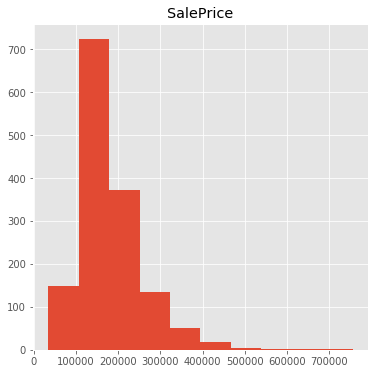

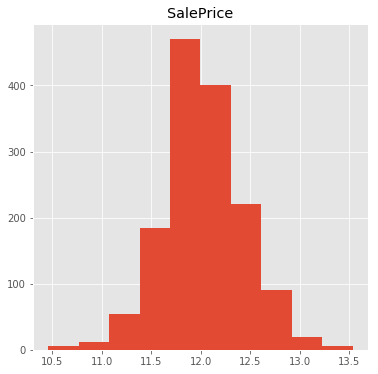

In [26]:
df_train_label = df_train_label.astype(int)
df_train_label_log = np.log( df_train_label )
df_train_label.hist()
df_train_label_log.hist()

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn import linear_model

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_train, df_train_label_log, test_size=0.2, random_state=0)

linear_1 = linear_model.LinearRegression()
linear_1.fit(X_train, y_train)   
preds = linear_1.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.241398


Certainly overfit. Need to do some feature selection

Grid Search for best lambda

{'alpha': 0.0001353047774579806} 0.02189182428665375


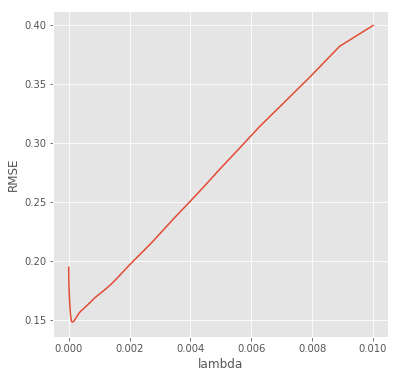

In [28]:
from sklearn.linear_model import Ridge, Lasso, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
alphas = np.logspace(-7, -2, 100)
grid = GridSearchCV(estimator=Lasso(normalize=True),
    param_grid=dict(alpha=alphas), cv=5, scoring='neg_mean_squared_error' )

#grid = GridSearchCV(estimator=Lasso(),
#    param_grid=dict(alpha=alphas), cv=5, scoring='r2' )

grid.fit(df_train, df_train_label_log) # entire datasets were fed here

print (grid.best_params_, -grid.best_score_)

#means = grid.cv_results_['mean_test_score']
#stds = grid.cv_results_['std_test_score']
#for mean, std, params in zip(means, stds, grid.cv_results_['params']):
#    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    
scores = [np.sqrt(-x) for x in grid.cv_results_['mean_test_score'] ] # This is for RMSE
#scores = [x for x in grid.cv_results_['mean_test_score'] ]  #This is for R^2 score
plt.plot(alphas, scores)
plt.xlabel('lambda')
plt.ylabel('RMSE')
#plt.ylabel('R^2')
plt.show()

# the lambda is very small. Therefore, there is almost no regulization going on.


In [50]:
model_lasso = Lasso(alpha= grid.best_params_['alpha'], normalize=True)
model_lasso.fit(df_train, df_train_label_log)
print ("R^2:", model_lasso.score(df_train, df_train_label_log)) 

R^2: 0.9044592552549022


RMSE: 0.123427
KstestResult(statistic=0.9559169626670252, pvalue=0.0)


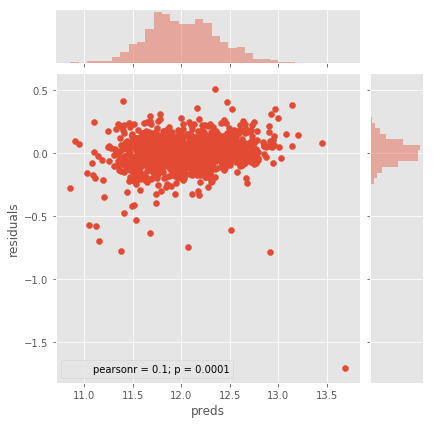

In [49]:
preds = df_train_label_log.copy()
preds["preds"] = model_lasso.predict(df_train)
preds["residuals"] = preds["SalePrice"] - preds["preds"]
sns.jointplot(x = "preds", y = "residuals",  data=preds )

rmse = np.sqrt(mean_squared_error(df_train_label_log, preds["preds"]))
print("RMSE: %f" % (rmse))

from scipy.stats import kstest
x = np.random.normal(0,1,1000)
test_stat = kstest( residuals, 'norm')  #the residuals is not normally distributed.
print(test_stat)



Lasso picked 78 variables and eliminated the other 173 variables


Text(0.5,1,'Coefficients in the Lasso Model')

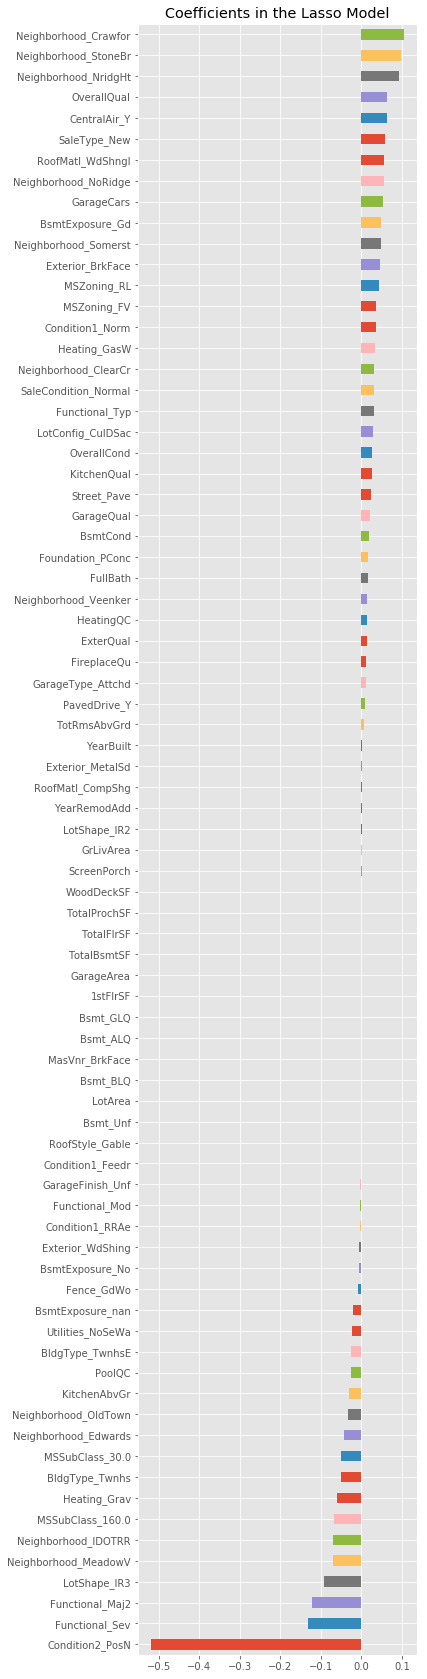

In [21]:
coef = pd.Series(model_lasso.coef_, index = df_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
plt.figure()
plt.rcParams['figure.figsize'] = (15.0, 3.0)

imp_coef = pd.concat([coef[coef != 0].sort_values()])
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")


In [73]:
import pickle
with open('linear.pkl', 'wb') as handle:
    pickle.dump(model_lasso, handle, protocol=pickle.HIGHEST_PROTOCOL)

0.12342191488981644
0.12150098621480014
0.12150098621480014
Lasso picked 100 variables and eliminated the other 150 variables


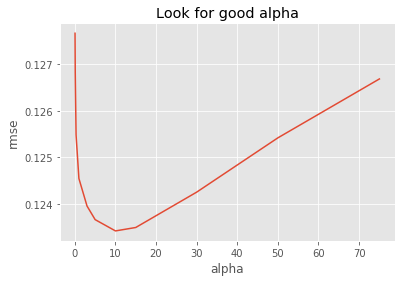

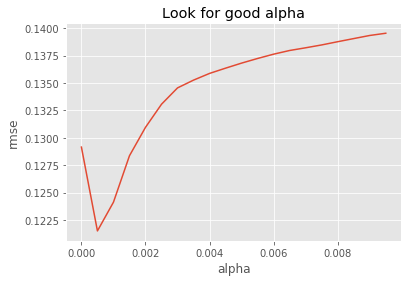

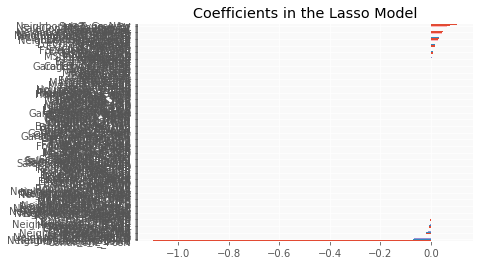

<Figure size 432x2592 with 0 Axes>

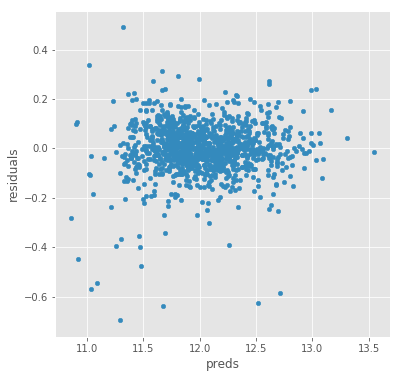

In [6]:
from sklearn.linear_model import Ridge, Lasso, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    # mean_squared_error in the cross_val_score returns the negative MSE value.
    rmse= np.sqrt(-cross_val_score(model, df_train, df_train_label_log, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)

model_ridge = Ridge(normalize=True)
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Look for good alpha")
plt.xlabel("alpha")
plt.ylabel("rmse")
print( cv_ridge.min() )  #cross different alpha sampled, look for the best mean rmse for all the cross validation

plt.figure()
model_lasso = Lasso(normalize=True)
alphas = np.arange(1e-10, 1e-2, 1e-4*5 )
cv_lasso = [rmse_cv(Lasso(alpha = alpha)).mean() for alpha in alphas]
#cv_lasso = [rmse_cv(Lasso(alpha = alpha, normalize=True, max_iter=1e5 )).mean() for alpha in alphas]
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "Look for good alpha")
plt.xlabel("alpha")
plt.ylabel("rmse")
print( cv_lasso.min() )
model_lasso = LassoCV( alphas = alphas ).fit(X_train, y_train)
print ( rmse_cv(model_lasso).mean() )

coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

plt.figure()
plt.rcParams['figure.figsize'] = (6.0, 36.0)
imp_coef = pd.concat([coef.sort_values()])
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

plt.figure()
plt.rcParams['figure.figsize'] = (6.0, 6.0)
preds = y_train.copy()
preds["preds"] = model_lasso.predict(X_train)
preds["residuals"] = preds["SalePrice"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
